### Solar Potential of Low Income Communities in the United States

This code cleans and combines various datasets from:
- Google Sunroof
- Energy Equity Project
- Justice 40

In [1]:
import pandas as pd
import geopandas as gpd

In [34]:
#Load Datasets

## load Project Sunroof Data
sr_data = pd.read_csv("data/project-sunroof-census_tract.csv", index_col="region_name")
sr_data = sr_data.rename_axis(index={"region_name": "GEOID"})
sr_data.index = sr_data.index.astype(int)
#print(sr_data.head(5))

#load Energy Equity Project Data
eep_data = pd.read_csv("data/eep_final_data.csv", index_col="GEOID")
eep_data.index = eep_data.index.astype(int)
#print(eep_data.head(5))

#load Justice40 Data
j40_data = pd.read_csv("data/1.0-communities.csv", index_col="Census tract 2010 ID")
j40_data = j40_data.rename(columns={"Census tract 2010 ID": "GEOID"})
j40_data.index = j40_data.index.astype(int)
#print(j40_data.head(5))

#load Opportunity Zone Data
oz_data = pd.read_csv("data/Opportunity_Zone_ExportTable1.csv", index_col="Tract_Boundaries_ID")
oz_data = oz_data.rename(columns={"Tract_Boundaries_ID": "GEOID"})
oz_data.index = oz_data.index.astype(int)
#print(oz_data.head(5))

           state_name    lat_max    lat_min    lng_max    lng_min    lat_avg   
GEOID                                                                          
1001020100    Alabama  32.505161  32.449730 -86.475128 -86.510422  32.477184  \
1001020200    Alabama  32.489342  32.456120 -86.465378 -86.481270  32.474255   
1001020300    Alabama  32.491909  32.459209 -86.450684 -86.470871  32.475426   
1001020400    Alabama  32.493690  32.447208 -86.432381 -86.453941  32.472000   
1001020500    Alabama  32.485748  32.424000 -86.411346 -86.438423  32.458832   

              lng_avg  yearly_sunlight_kwh_kw_threshold_avg  count_qualified   
GEOID                                                                          
1001020100 -86.490082                               1095.65              591  \
1001020200 -86.473381                               1095.65              718   
1001020300 -86.460190                               1095.65             1121   
1001020400 -86.443619                  

/var/folders/67/r87g720s2653g554zdhtz1vh0000gn/T/ipykernel_9467/1616357985.py:15: DtypeWarning: Columns (18,26,70,72,85,131) have mixed types. Specify dtype option on import or set low_memory=False.
  j40_data = pd.read_csv("data/1.0-communities.csv", index_col="Census tract 2010 ID")


In [12]:

#load Energy Equity Project geojson for geometry
eep_geodata = gpd.read_file("data/eep_final_simplified.json")

In [16]:
#Extract GEOID and Geometry to join into other datasets later
tract_geoid = eep_geodata[["GEOID", "geometry"]]
tract_geoid["GEOID"] = tract_geoid["GEOID"].astype(int)
#tract_geo_id = tract_geo_id.set_index("GEOID")
print(tract_geoid.head(5))


         GEOID                                           geometry
0  13163960300  POLYGON ((-82.66192 33.12633, -82.66192 33.126...
1  37109071201  POLYGON ((-80.99344 35.47878, -80.99386 35.471...
2  25025050200  POLYGON ((-71.04003 42.37865, -71.03907 42.374...
3  17031230200  POLYGON ((-87.71342 41.91359, -87.71331 41.910...
4  41047001607  POLYGON ((-122.99032 44.96821, -122.99031 44.9...


/usr/local/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [35]:
# Create Category 1 Dataset for Main Criteria 
# based on 45D(e) Internal Revenue Service Guidelines 
# which defines "low-income community" census tracts where: 
# 1) Poverty rate > 20% OR 
# 2) Median family income <= 80% of statewide MFI

# Create a new column 'qualified' and initialize it with False
oz_data['qualified'] = False

columns_to_convert = ['Poverty_csv_Percent_below_pover', 'MedianFamilyIncome_csv_Median_F', 'State_MedFamInc', 'Metro_MedFamInc']

# Convert selected columns to float, ignoring non-numeric values
oz_data[columns_to_convert] = oz_data[columns_to_convert].apply(pd.to_numeric, errors='coerce')


# Set 'qualified' if poverty percentage is >= 20
oz_data.loc[oz_data['Poverty_csv_Percent_below_pover'] >= 20, 'qualified'] = True

# Set 'qualified' if tract is in metro area and median family income does not exceed 
# the greater of 80% statewide median family income and 80% metropolitan area median family income
oz_data.loc[(oz_data['Tract_by_Metro_Area_csv_class'] == "Metro") & 
             (oz_data['MedianFamilyIncome_csv_Median_F'] < oz_data[['State_MedFamInc', 'Metro_MedFamInc']].max(axis=1)), 'qualified'] = True

# Set 'qualified' if tract not in a metro area and median family income does not exceed 80% statewide median family income
oz_data.loc[(oz_data['Tract_by_Metro_Area_csv_class'] != "Metro") & 
             (oz_data['MedianFamilyIncome_csv_Median_F'] < 0.8*oz_data['State_MedFamInc']), 'qualified'] = True

oz_data_qualified = oz_data.loc[oz_data["qualified"] == True]

print(oz_data_qualified.head)

<bound method NDFrame.head of               OID_  Tract_Boundaries_NAME Tract_Boundaries_STATE_NAME   
GEOID                                                                   
1001020200       2             10010202.0                     Alabama  \
1001020300       3             10010203.0                     Alabama   
1001020700       7             10010207.0                     Alabama   
1001020900      10             10010209.0                     Alabama   
1001021000      11             10010210.0                     Alabama   
...            ...                    ...                         ...   
56031959100  72720            560319591.0                     Wyoming   
56031959400  72721            560319594.0                     Wyoming   
56033000400  72725            560330004.0                     Wyoming   
56041975400  72748            560419754.0                     Wyoming   
56045951300  72753            560459513.0                     Wyoming   

            Tract_Bo

         GEOID                                           geometry   OID_   
0  13163960300  POLYGON ((-82.66192 33.12633, -82.66192 33.126...  19942  \
1  25025050200  POLYGON ((-71.04003 42.37865, -71.03907 42.374...  32161   
2  17031230200  POLYGON ((-87.71342 41.91359, -87.71331 41.910...  20892   
3   6037294610  POLYGON ((-118.26331 33.79115, -118.26266 33.7...   5684   
4  22017021900  POLYGON ((-93.78026 32.50360, -93.78027 32.494...  26955   

   Tract_Boundaries_NAME Tract_Boundaries_STATE_NAME   
0            131639603.0                     Georgia  \
1            250250502.0               Massachusetts   
2            170312302.0                    Illinois   
3             60372946.1                  California   
4            220170219.0                   Louisiana   

  Tract_Boundaries_ST_ABBREV   
0                         GA  \
1                         MA   
2                         IL   
3                         CA   
4                         LA   

             

<Axes: >

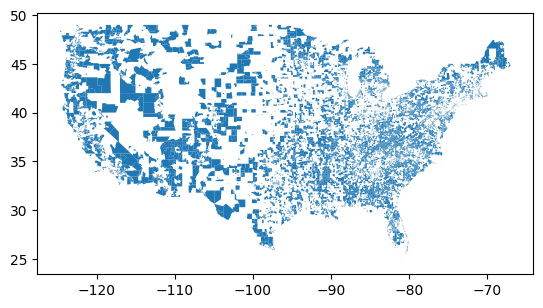

In [37]:
#Map eligible census tracts
#extract geometry attributes to use to map other datasets
oz_geodata = tract_geoid.merge(oz_data_qualified, on='GEOID')
print(oz_geodata.head(5))

#Map qualified tracts
oz_geodata.plot()

In [ ]:
# Create Dataset for Proposed Additional Category: Geographic
# CEJST Disadvantaged Tract where either:
# 1) >= 90th percentile for energy burden AND >= 65th percentile for low-income
# 2) >= 90th percentile for PM2.5 exposure AND >= 65th percentile for low-income

#Get energy burden tracts & PM2.5 exposure tracts
cat1_data = j40_data.loc[(j40_data["Greater than or equal to the 90th percentile for energy burden and is low income?"]) 
                                 | (j40_data["Greater than or equal to the 90th percentile for PM2.5 exposure and is low income?"])]
#print(cat1_data.head)

#TODO add geometry, plot on map
# cat1_geodata = tract_geo_id.merge(cat1_data, on="GEOID")
# print(cat1_geodata.head)
#TODO Plot based on energy burden percentage, pm2.5 number (which areas are highest? any patterns?)
# cat1_geodata.plot("Greater than or equal to the 90th percentile for energy burden and is low income?")
#TODO Create shapefiles for datasets

#Tract part of Persistent Poverty County
#TODO Download PPC data from Department of Agriculture
